### 지역별 공원 및 등록현황 관련 데이터 분석

- 가설: 지역에 공원이 많을수록 반려동물 등록건수가 많은가?

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mysql.connector
import koreanize_matplotlib 
import json
from folium.plugins import MarkerCluster

%matplotlib inline

In [92]:
conn = mysql.connector.connect(
    host = "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [93]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, p.name, p.lat, p.lng
                from pet_infra p
                LEFT JOIN infra_category c ON p.category_id = c.id
                LEFT JOIN region_list l ON p.region_id = l.id
                WHERE c.type LIKE '%공원%';
                """)

result = cursor.fetchall()

infra_df = pd.DataFrame(result, columns=["region", "type", "name", "lat", "lng"])
infra_df.head()

,region,type,name,lat,lng
0,은평구,공원,은평구 반려견 놀이터,37.490620,126.919205
1,광진구,공원,어린이대공원,37.549362,127.081810
2,마포구,공원,월드컵공원 반려견놀이터,37.563873,126.893501
3,동작구,공원,보라매공원,37.492680,126.919136
4,서초구,공원,매헌시민의숲,37.470684,127.035599


In [94]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, p.breed, r.count
                from region_pet_regist r
                LEFT JOIN region_list l ON r.region_id = l.id
                LEFT JOIN pet_type p ON r.pet_type_id = p.id;
                """)

result = cursor.fetchall()

regist_df = pd.DataFrame(result, columns=["region", "breed", "count"])
regist_df.head()

,region,breed,count
0,종로구,골든 리트리버,156
1,종로구,그레이 하운드,5
2,종로구,달마시안,3
3,종로구,도베르만,21
4,종로구,라브라도 리트리버,136


/tmp/ipykernel_19907/1502970712.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_infra_data, x="region", y="park_count", palette="coolwarm")


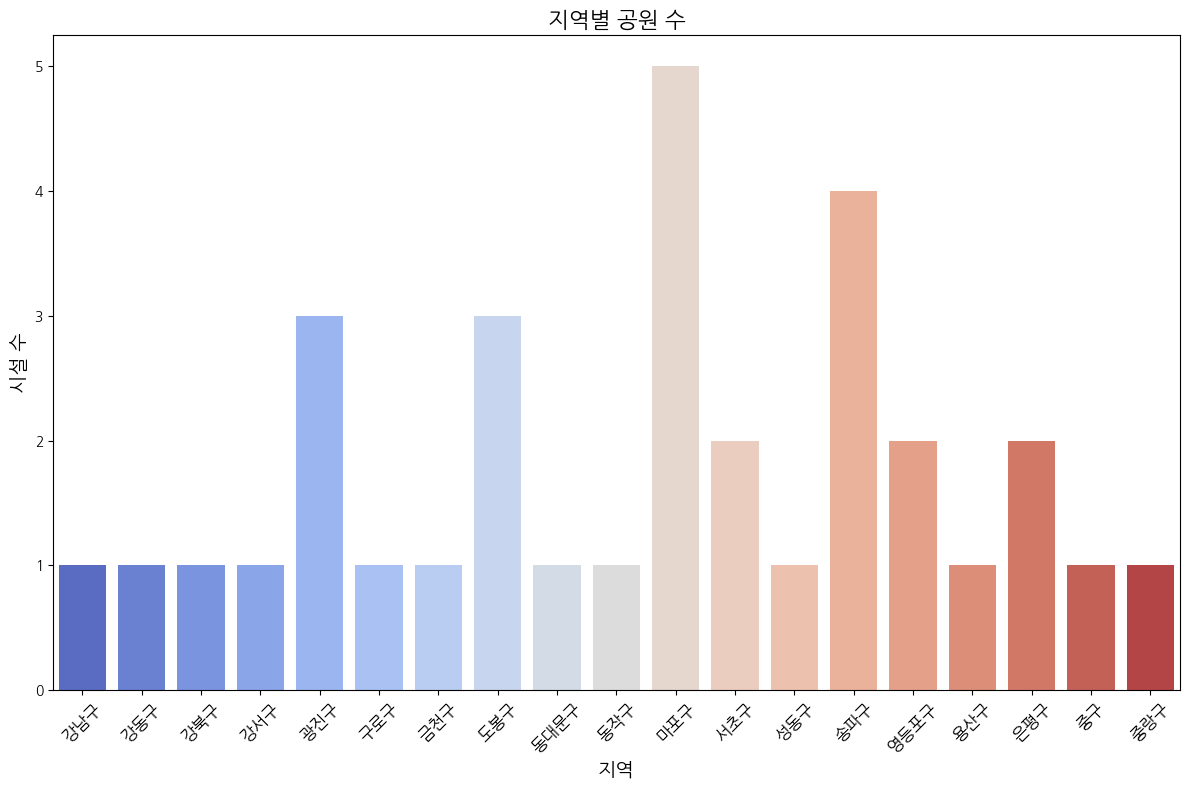

In [95]:
region_infra_data = infra_df.groupby("region")['type'].count().reset_index()
region_infra_data.columns = ["region", "park_count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=region_infra_data, x="region", y="park_count", palette="coolwarm")

plt.title("지역별 공원 수", fontsize=16)
plt.xlabel("지역", fontsize=14)
plt.ylabel("시설 수", fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.show()


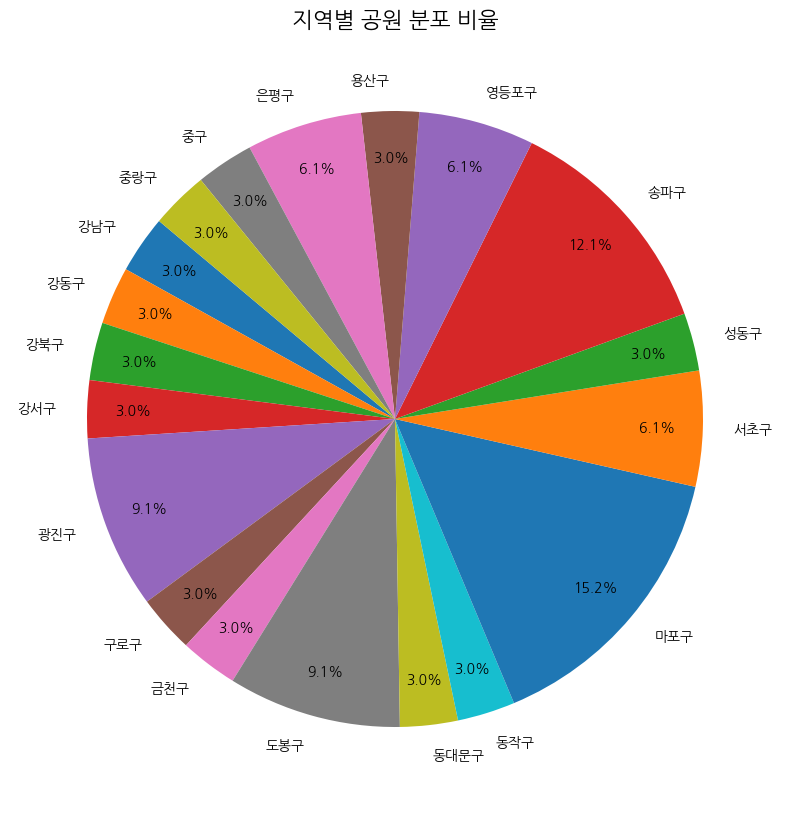

In [96]:
park_counts = region_infra_data.set_index("region")["park_count"]

plt.figure(figsize=(12, 10))
plt.pie(
    park_counts,
    labels=park_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    labeldistance=1.1,
    pctdistance=0.85,
)
plt.title("지역별 공원 분포 비율", fontsize=16)
plt.show()

In [97]:
geo_path = "../data/skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))
geo_str

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '강동구',
   'properties': {'code': '11250',
    'name': '강동구',
    'name_eng': 'Gangdong-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.11519584981606, 37.557533180704915],
      [127.16683184366129, 37.57672487388627],
      [127.18408792330152, 37.55814280369575],
      [127.16530984307447, 37.54221851258693],
      [127.14672806823502, 37.51415680680291],
      [127.12123165719615, 37.52528270089],
      [127.1116764203608, 37.540669955324965],
      [127.11519584981606, 37.557533180704915]]]}},
  {'type': 'Feature',
   'id': '송파구',
   'properties': {'code': '11240',
    'name': '송파구',
    'name_eng': 'Songpa-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.0690698130372, 37.522279423505026],
      [127.10087519791962, 37.524841220167055],
      [127.1116764203608, 37.540669955324965],
      [127.12123165719615, 37.52528270089

In [98]:
region_infra_data = region_infra_data.set_index("region")

map_center = [infra_df["lat"].mean(), infra_df["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

choropleth = folium.Choropleth(
    geo_data=geo_str,
    data=region_infra_data,
    columns=[region_infra_data.index, "park_count"],
    key_on="feature.id",
    fill_color="PuRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="지역별 공원 수"
).add_to(m)

folium.GeoJson(
    geo_str,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"], 
        aliases=["지역명:"],
        localize=False
    ),
    style_function=lambda x: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0 
    }
).add_to(m)
m

- 자치구별 등록현황

/tmp/ipykernel_19907/3924411601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_total, x="region", y="regist_count", palette="coolwarm")


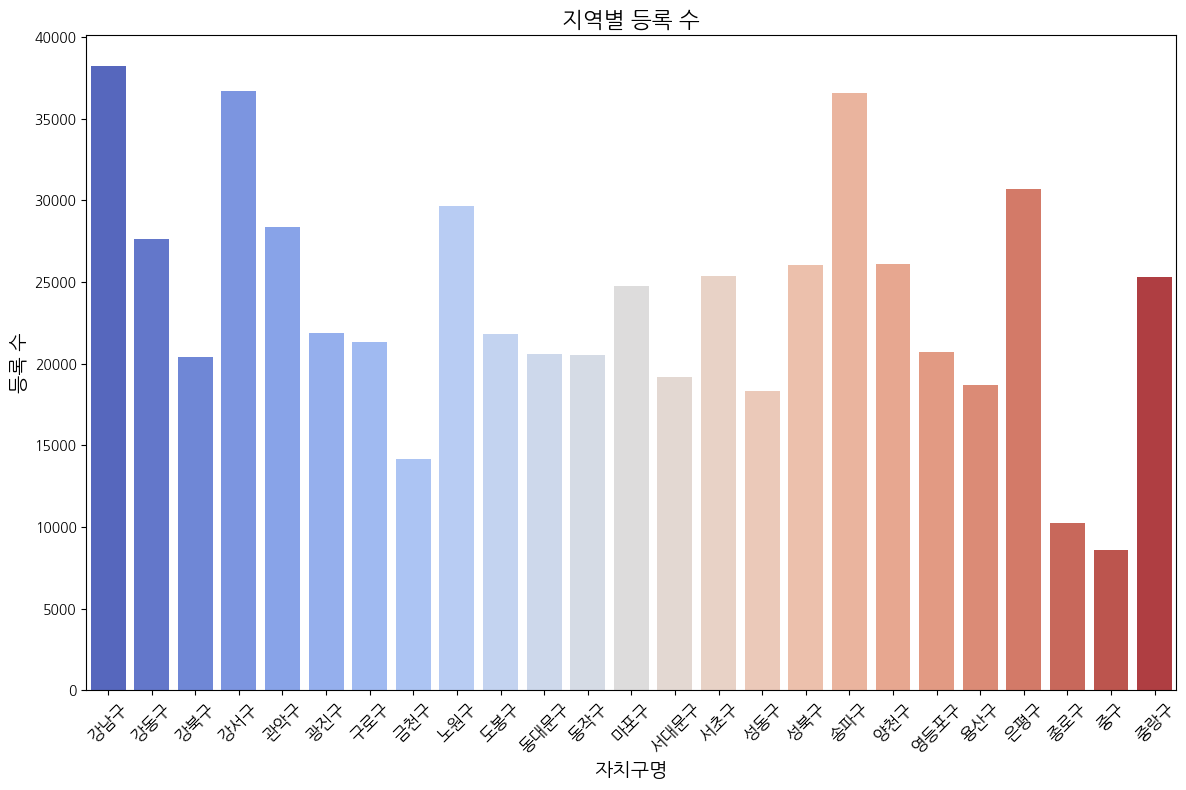

In [99]:
region_total = regist_df.groupby("region")["count"].sum().reset_index()
region_total.columns = ["region", "regist_count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=region_total, x="region", y="regist_count", palette="coolwarm")

plt.title("지역별 등록 수", fontsize=16)
plt.xlabel("자치구명", fontsize=14)
plt.ylabel("등록 수", fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.show()


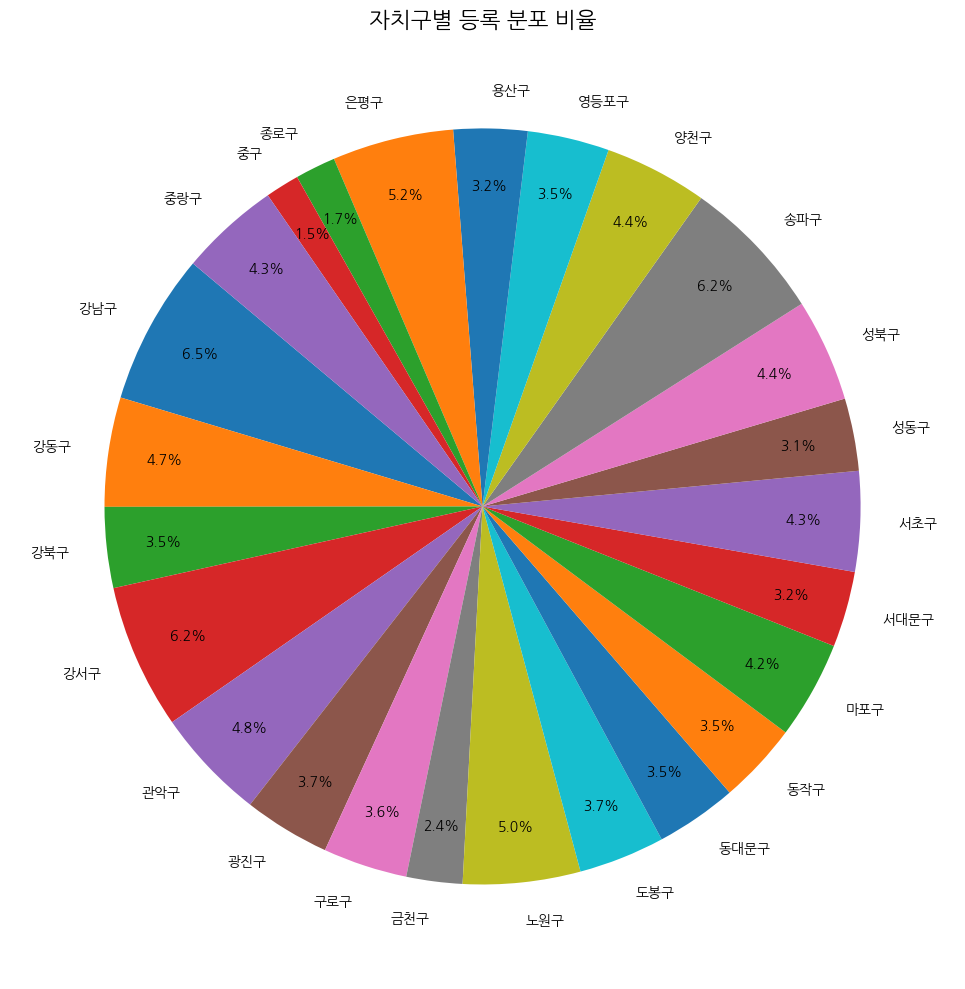

In [100]:
region_total = region_total.set_index("region")

plt.figure(figsize=(12, 10))
plt.pie(
    region_total["regist_count"],
    labels=region_total.index,
    autopct="%1.1f%%",
    startangle=140,
    labeldistance=1.1,
    pctdistance=0.85,
)
plt.title("자치구별 등록 분포 비율", fontsize=16)
plt.tight_layout()
plt.show()

In [101]:
merged_df = pd.concat([park_counts, region_total], axis=1)
merged_df.head()

,park_count,regist_count
region,,
강남구,1.0,38218
강동구,1.0,27643
강북구,1.0,20432
강서구,1.0,36671
광진구,3.0,21875


In [102]:
corr = merged_df[["park_count", "regist_count"]].corr()

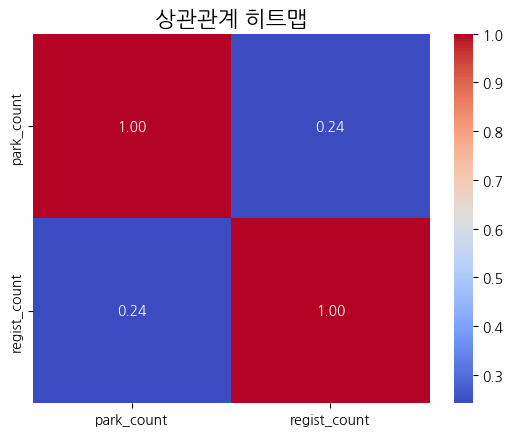

In [103]:
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관관계 히트맵", fontsize=16)
plt.show()

#### 결론
- 기본적으로 모든 자치구에는 공원이 1개는 있는것으로 보이고 공원이 가장 많은 자치구는 강남입니다. 하지만 등록 건 수가 많지 않은 것으로 보입니다.
- 공원수와 등록 수는 음의 상관관계가 있어 공원이 많은 지역일수록 반려동물 등록 건수가 줄어드는 경향이 있습니다.
- 따라서 지역에 공원이 많을수록 반려동물 등록건 수 많은것은 아닙니다.